# Data Loading and Preprocessing

In [1]:
import yfinance as yf
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date

# Initialize Spark session
spark = SparkSession.builder.appName("StockAnalysis").getOrCreate()

# Download data
tickers = ["AAPL", "MSFT", "GOOGL", "NFLX", "TSLA"]
data = yf.download(tickers, start="2021-01-01", end="2023-12-31", group_by="ticker")

# Stack data and reset index
data = data.stack(level=0, future_stack=True).reset_index()

# Print column names to verify
print(data.columns)



[*********************100%***********************]  5 of 5 completed


Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume'],
      dtype='object', name='Price')


In [2]:
# Rename columns based on observed output
data.columns = ["Date", "Ticker", "Open", "High", "Low", "Close", "Adj Close", "Volume"]

# Drop 'Adj Close'
data = data.drop(columns=["Adj Close"])

# Convert to Spark DataFrame
df = spark.createDataFrame(data)
df = df.withColumn("Date", to_date(col("Date")))

# Handle missing values
df = df.na.drop()
df.show(5)


+----------+------+------------------+------------------+------------------+------------------+---------+
|      Date|Ticker|              Open|              High|               Low|             Close|   Volume|
+----------+------+------------------+------------------+------------------+------------------+---------+
|2021-01-04|  MSFT|222.52999877929688|             223.0|214.80999755859375|217.69000244140625| 37130100|
|2021-01-04|  TSLA|239.82000732421875|  248.163330078125|239.06333923339844| 243.2566680908203|145914600|
|2021-01-04|  AAPL|133.52000427246094|133.61000061035156|126.76000213623047|129.41000366210938|143301900|
|2021-01-04|  NFLX|             539.0| 540.7999877929688| 515.0900268554688| 522.8599853515625|  4444400|
|2021-01-04| GOOGL|              88.0| 88.12449645996094| 85.35700225830078| 86.30650329589844| 37324000|
+----------+------+------------------+------------------+------------------+------------------+---------+
only showing top 5 rows



 # Data Aggregation

(a) Calculate daily, weekly, and monthly average closing prices for a selected stock.

In [6]:
from pyspark.sql.functions import avg, year, month, weekofyear


apple_df = df.filter(df.Ticker == "AAPL")

# Calculate daily average closing price
daily_avg = apple_df.groupBy("Date").agg(avg("Close").alias("Daily_Avg_Close"))
daily_avg.show(5)

# Calculate weekly average closing price
weekly_avg = apple_df.groupBy(year("Date").alias("Year"), weekofyear("Date").alias("Week")) \
                     .agg(avg("Close").alias("Weekly_Avg_Close")) \
                     .orderBy("Year", "Week")
weekly_avg.show(5)

# Calculate monthly average closing price
monthly_avg = apple_df.groupBy(year("Date").alias("Year"), month("Date").alias("Month")) \
                      .agg(avg("Close").alias("Monthly_Avg_Close")) \
                      .orderBy("Year", "Month")
monthly_avg.show(5)


+----------+------------------+
|      Date|   Daily_Avg_Close|
+----------+------------------+
|2021-01-27|142.05999755859375|
|2021-06-22|133.97999572753906|
|2021-08-27|148.60000610351562|
|2021-10-11|142.80999755859375|
|2022-03-28|175.60000610351562|
+----------+------------------+
only showing top 5 rows

+----+----+------------------+
|Year|Week|  Weekly_Avg_Close|
+----+----+------------------+
|2021|   1| 129.9979995727539|
|2021|   2|128.94400024414062|
|2021|   3|133.95000076293945|
|2021|   4|139.43800048828126|
|2021|   5|135.44400024414062|
+----+----+------------------+
only showing top 5 rows

+----+-----+------------------+
|Year|Month| Monthly_Avg_Close|
+----+-----+------------------+
|2021|    1| 133.0368423461914|
|2021|    2|  131.531578867059|
|2021|    3|121.87130372420602|
|2021|    4|131.81285785493395|
|2021|    5|126.78400001525878|
+----+-----+------------------+
only showing top 5 rows



(b)Identify stock with the highest average monthly price for a given year

In [13]:
from pyspark.sql.functions import year, month, avg, col

# Filter data for the year 2023
data_2023 = df.filter(year(col("Date")) == 2023)

# Calculate the average monthly closing price for each stock
monthly_avg = data_2023.groupBy("Ticker", year("Date").alias("Year"), month("Date").alias("Month")).agg(avg("Close").alias("Monthly_Avg_Close"))

# Find the stock with the highest average monthly closing price
# Order by monthly average price in descending order
highest_avg_stock = monthly_avg.orderBy(col("Monthly_Avg_Close").desc()).limit(1)

# Show the result
highest_avg_stock.show()


+------+----+-----+-----------------+
|Ticker|Year|Month|Monthly_Avg_Close|
+------+----+-----+-----------------+
|  NFLX|2023|   12|474.0595001220703|
+------+----+-----+-----------------+



# Exploratory Data Analysis

In [14]:
import matplotlib.pyplot as plt

# Calculate daily price change (volatility)
volatility = df.withColumn("Price_Fluctuation", col("High") - col("Low"))
volatility_stats = volatility.groupBy("Ticker").agg(avg("Price_Fluctuation").alias("Avg_Price_Fluctuation")) \
                             .orderBy(col("Avg_Price_Fluctuation").desc())
volatility_stats.show()


+------+---------------------+
|Ticker|Avg_Price_Fluctuation|
+------+---------------------+
|  NFLX|    12.24226993393613|
|  TSLA|    11.34459503903332|
|  MSFT|    5.912895678840627|
|  AAPL|    3.321952627316256|
| GOOGL|    2.708428270155057|
+------+---------------------+



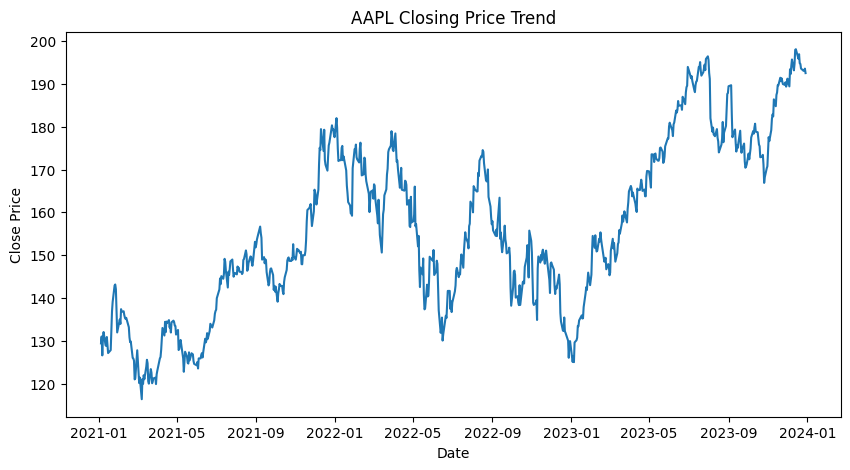

In [15]:

# Plotting closing price trend for a specific stock (e.g., AAPL)
aapl_data = df.filter(df.Ticker == "AAPL").select("Date", "Close").toPandas()
plt.figure(figsize=(10, 5))
plt.plot(aapl_data["Date"], aapl_data["Close"])
plt.title("AAPL Closing Price Trend")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


# Machine Learning

In [20]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Step 1: Prepare the Data
# Select relevant columns and rename 'Close' to 'label' for PySpark's MLlib to recognize it as the target variable
data = df.select("Open", "High", "Low", "Volume", col("Close").alias("label"))

# Assemble features into a single vector column
feature_cols = ["Open", "High", "Low", "Volume"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(data).select("features", "label")

# Split data into training and test sets (80% training, 20% test)
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=1234)

# Step 2: Build and Train the Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

# Step 3: Evaluate Model Performance
# Make predictions on the test set
predictions = lr_model.transform(test_data)


# Evaluate model using R^2 metric
r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)

print(f"R^2 (Coefficient of Determination): {r2}")


R^2 (Coefficient of Determination): 0.9996756733267945
